# Import

In [1]:
# base
import pandas as pd 
import numpy as np

# graph
import matplotlib.pyplot as plt
import seaborn as sns

# data processing
import datetime
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# FranceAgrimer data

In [2]:
## Import and preprocess franceAgriMer database
fam_df = pd.read_csv('famStocks.csv', dtype= {'DEP':str})

# Remove whitespace
for col in fam_df.select_dtypes(include='object').columns:
    fam_df[col] = fam_df[col].str.strip()
    
# Remove useless columns
fam_df.drop(['REGION','Unnamed: 13','DEPARTEMENT'], axis= 1, inplace=True)

# create DATE from ANNEE + MOIS
fam_df['DATE'] = pd.to_datetime(pd.DataFrame({'year' : fam_df['ANNEE'],
                                              'month' : fam_df['MOIS'],
                                              'day' : 1}))

# drop the now useless temporal columns 
fam_df.drop(['ANNEE','MOIS'],axis=1, inplace=True)

# Filter ESPECES
especes_vec = ['Avoine', 'Blé dur', 'Blé tendre', 'Céréales autres', 'Maïs',
       'Orge', 'Seigle', 'Sorgho', 'Triticale', 'Féverole',
       'Légumineuses autres', 'Pois', 'Colza', 'Lin', 'Soja', 'Tournesol']

espece = especes_vec[4]

# the data will be Stocks + Stocks Depot

fam_df_esp = fam_df.loc[fam_df['ESPECES']== espece]

# add a column for the plot 
fam_df_esp['STOCKS_TOTAL'] = fam_df_esp['STOCKS']+fam_df_esp['STOCKS_DEPOTS']

fam_df_esp = fam_df_esp[['DEP','DATE','STOCKS_TOTAL']].reset_index(drop=True)

fam_df_esp = pd.pivot_table(fam_df_esp, index=['DEP'], columns='DATE', values='STOCKS_TOTAL').fillna(0)



/tmp/ipykernel_64270/3770168750.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam_df_esp['STOCKS_TOTAL'] = fam_df_esp['STOCKS']+fam_df_esp['STOCKS_DEPOTS']


# Temporal EDA

In [3]:
# reshape the DataFrame in a tidy format
value_vars = ["TOTAL_COLLECTE", "STOCKS", "STOCKS_DEPOTS", "ENTREE_DEPOT",
    "SORTIE_DEPOT", "REPRISE_DEPOT"]

fam_melt_df = pd.melt(fam_df, id_vars=['ESPECES','DEP','DATE','CAMPAGNE'], value_vars= value_vars)

fam_melt_df.head()

,ESPECES,DEP,DATE,CAMPAGNE,variable,value
0,Avoine,01,2000-07-01,2000/01,TOTAL_COLLECTE,2245.9
1,Avoine,01,2000-08-01,2000/01,TOTAL_COLLECTE,461.6
2,Avoine,01,2000-09-01,2000/01,TOTAL_COLLECTE,76.8
3,Avoine,01,2000-10-01,2000/01,TOTAL_COLLECTE,21.7
4,Avoine,01,2000-11-01,2000/01,TOTAL_COLLECTE,28.4


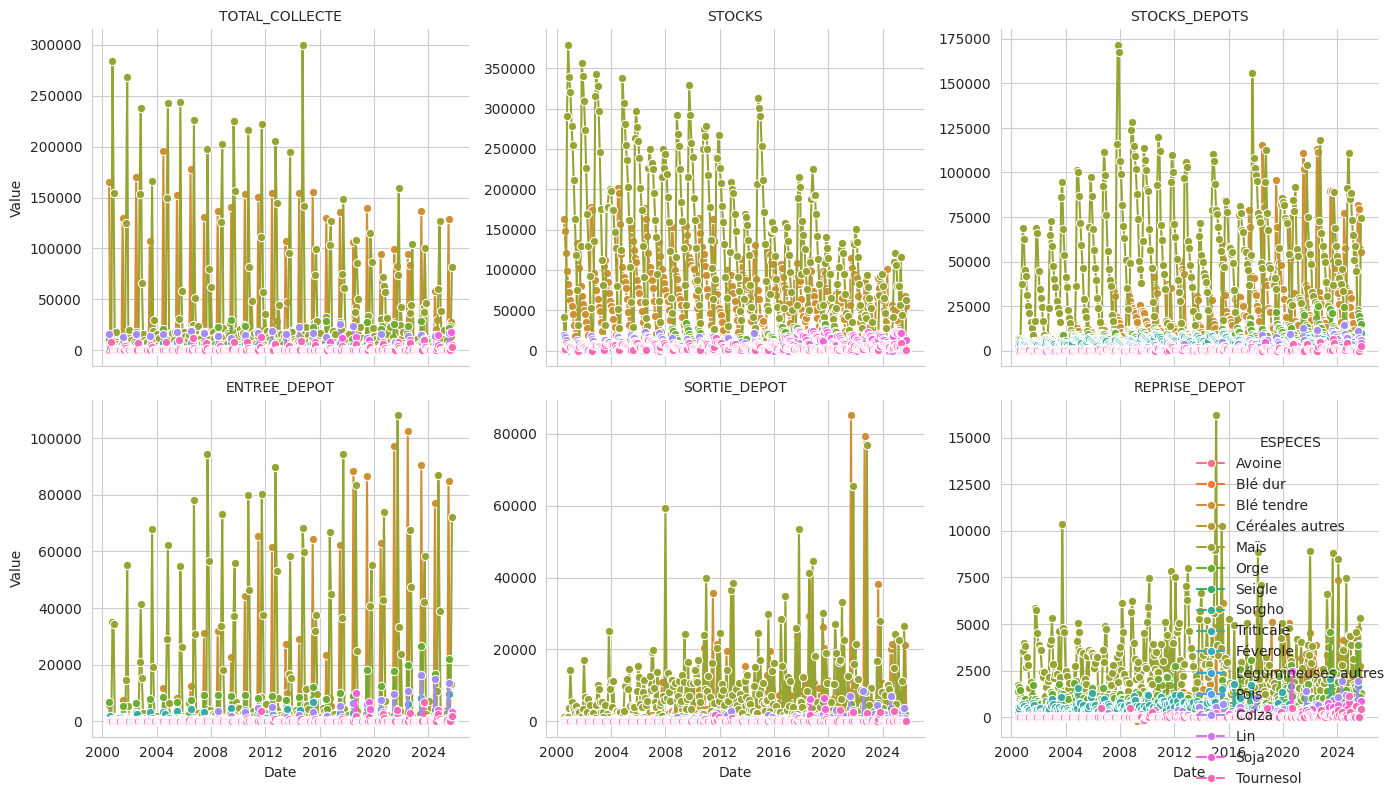

In [4]:
# Time series visual:

sns.set_style("whitegrid")

g = sns.FacetGrid(
    fam_melt_df.loc[fam_melt_df['DEP'] == '01',],
    col="variable",          # one subplot per variable
    hue="ESPECES",           # different colour for each species
    col_wrap=3,              # wrap columns if many variables
    height=4,                # height of each subplot (in inches)
    sharex=True, sharey=False
)


g.map(
    sns.lineplot,
    "DATE", "value",
    marker="o"
)

g.add_legend(title="ESPECES")          # creates the legend and stores it in g._legend
legend = g._legend                     # retrieve the actual Legend object
legend.set_loc('lower right')

g.set_axis_labels("Date", "Value")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

We observe:
- Seasonal patterns 
- Overall trend
- Not scaled among species

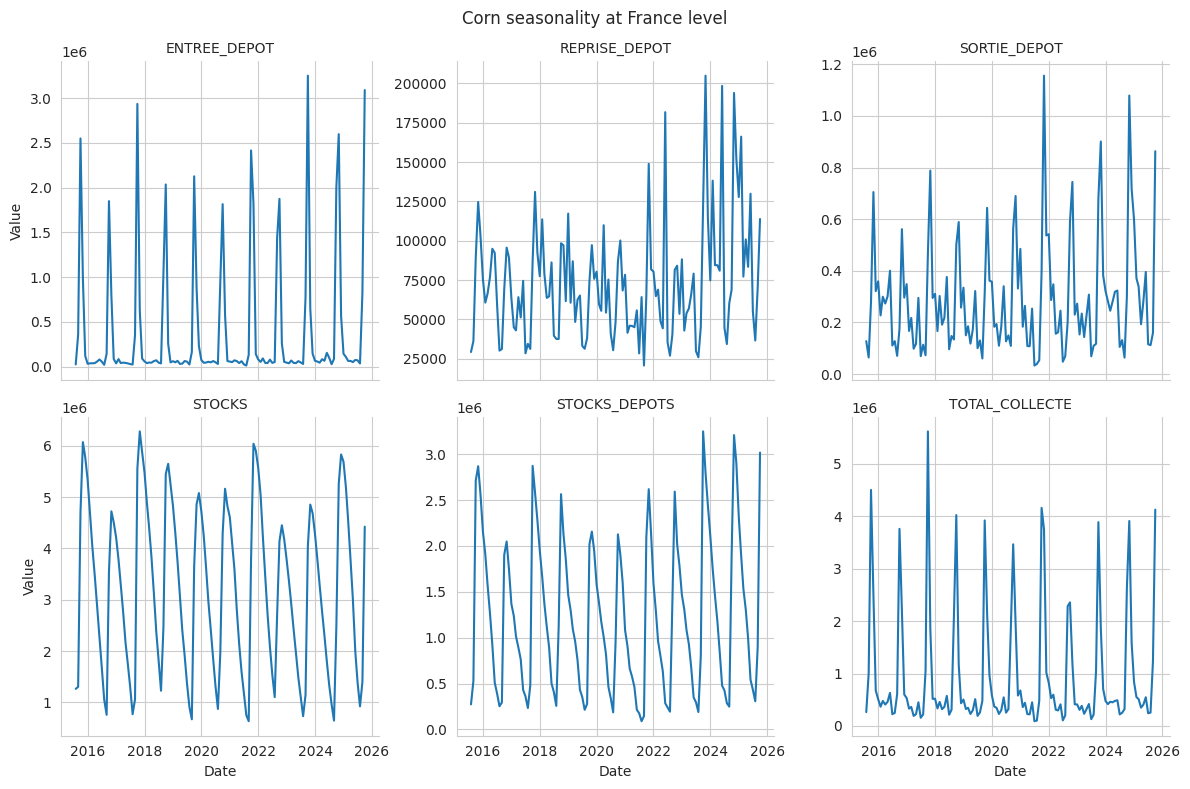

In [5]:
Trigger = ((fam_melt_df['ESPECES'] == espece)
           & (fam_melt_df['DATE'] > datetime.datetime(2015,7,2)))

sns.set_style("whitegrid")

g = sns.FacetGrid(
    fam_melt_df.loc[Trigger,:].groupby(['variable','DATE'], as_index=False).sum('DEP'),
    col="variable",          # separate column for each variable
    col_wrap=3,              # two columns before wrapping to next row (adjust as needed)
    height=4,
    sharex=True,
    sharey=False
)

g.map(
    sns.lineplot,
    "DATE", "value",
    estimator=None           # plot raw points
)

# Legend for ESPECES (appears once for the whole figure)

g.set_axis_labels("Date", "Value")
g.set_titles(col_template="{col_name}")

g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Corn seasonality at France level')

plt.tight_layout()
plt.show()

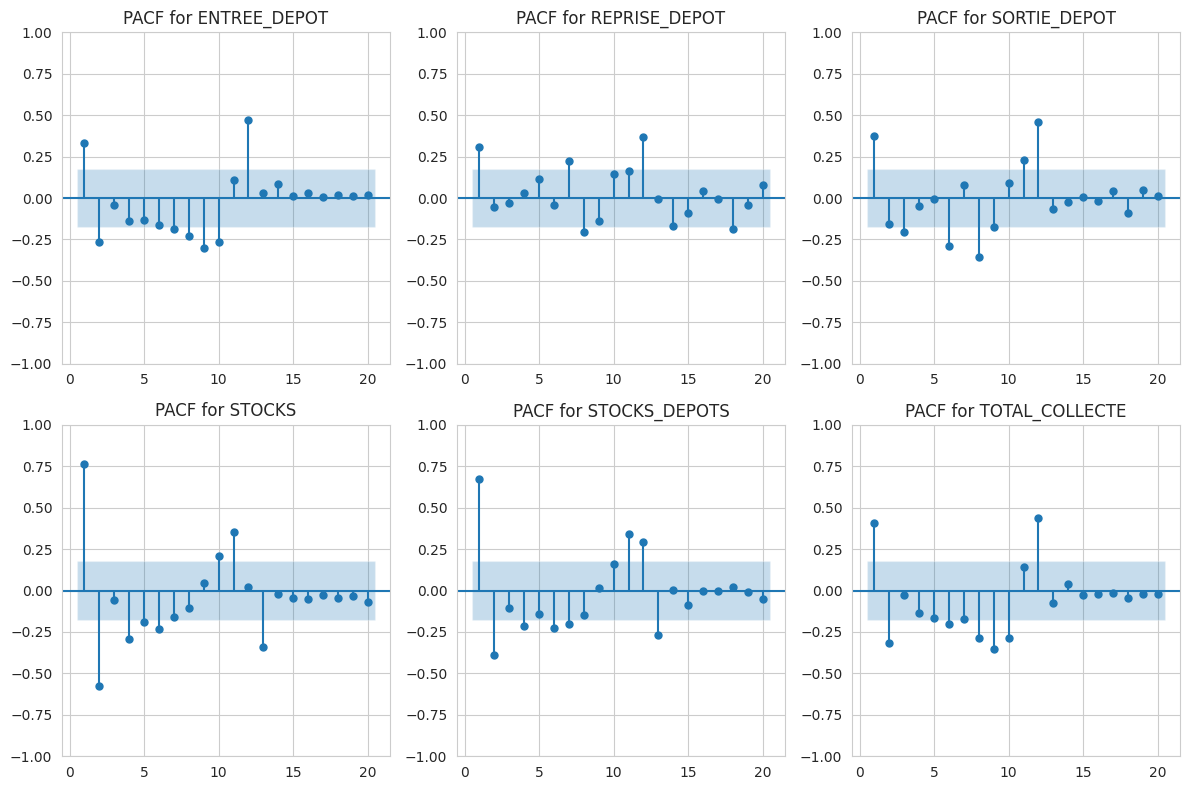

In [6]:
# Pivot the DataFrame to have variables as columns
pivot_df = fam_melt_df.loc[Trigger,:].groupby(['variable','DATE'], as_index=False).sum('DEP').pivot(index='DATE', columns='variable', values='value')

# Set up the grid for plotting
num_vars = len(pivot_df.columns)
fig, axes = plt.subplots(nrows=int(np.ceil(num_vars / 3)), ncols=3, figsize=(12, 4 * (num_vars / 3)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot PACF for each variable
for i, variable in enumerate(pivot_df.columns):
    plot_pacf(pivot_df[variable].dropna(), ax=axes[i], lags=20, zero = False)
    axes[i].set_title(f'PACF for {variable}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We see a strong autocorrelation over three lags: 1,12. 
The strength of the 1st, indicates that variables are not stationary.  
The 12th lag indicate a yearly seasonality. 

-> If i were to use SARIMA models, stationarity should be reached.  

## Relation between variables:

The dataset has 6 columns:
| TOTAL_COLLECTE | STOCKS | STOCKS_DEPOTS                 | ENTREE_DEPOT | SORTIE_DEPOT | REPRISE_DEPOT |
|----------------|--------|-------------------------------|--------------|--------------|---------------|
| Change         | Level  | Level                         | Change       | Change       | Change        |



The variation of STOCKS_DEPOTS is explained by ENTREE DEPOTS - REPRISE DEPOTS - SORTIE DEPOTS. There is a small residual on this relation caused by data quality. 

Also the variation of STOCKS = TOTAL_COLLECTE + X. Where X is the change in storage not explain by COLLECTE. 
I suppose that this change is entirely explained by sales minus purchases, thus I name X: VENTE_ACHATS 

We can resume all the columns in two aggregates:
ENTREE = TOTAL_COLLECTE + ENTREE_DEPOT
SORTIE = Var(STOCKS) - TOTAL_COLLECTE - SORTIE_DEPOT - REPRISE_DEPOT


In [ ]:
# ENTREE = TOTAL_COLLECTE + ENTREE_DEPOT
fam_df['ENTREE'] = fam_df['TOTAL_COLLECTE']+ fam_df['ENTREE_DEPOT']


# compute Var(STOCKS) the first lag difference of the STOCKS column for each combination of ESPECES and DEP
fam_df['LAG_DIFF'] = fam_df.groupby(['ESPECES', 'DEP'])['STOCKS'].transform(lambda x: x - x.shift(1)).round(3).fillna(0)

# SORTIE = Var(STOCKS) - TOTAL_COLLECTE - SORTIE_DEPOT - REPRISE_DEPOT
fam_df['SORTIE'] = fam_df['LAG_DIFF'] - fam_df['TOTAL_COLLECTE'] - fam_df['SORTIE_DEPOT'] - fam_df['REPRISE_DEPOT']


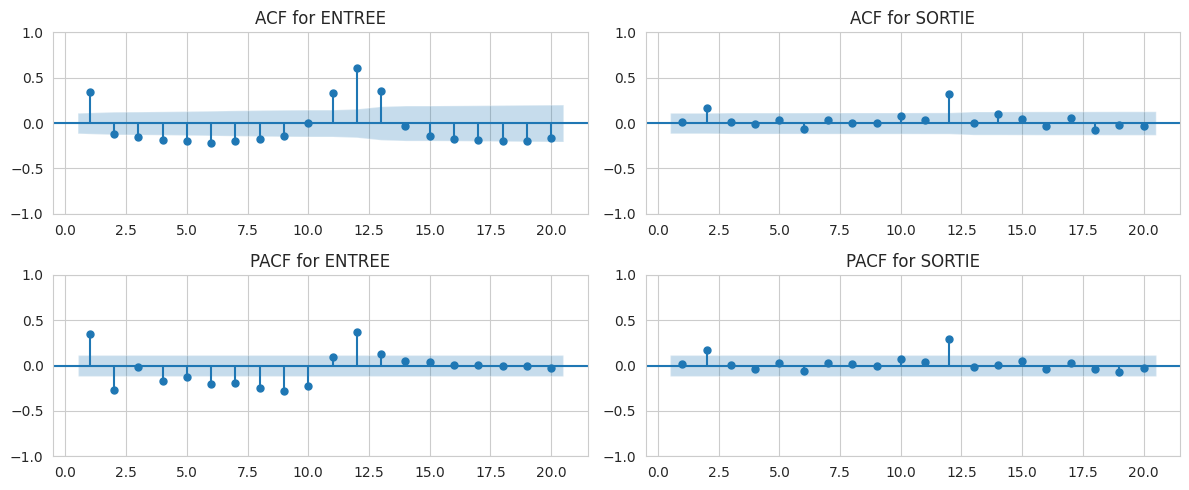

In [17]:
Trigger = ((fam_df['ESPECES'] == espece)
           & (fam_df['DEP'] == '01') )

fam_df.loc[Trigger,:].head()


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot PACF for each variable
ii = 2
plot_pacf(fam_df.loc[Trigger,'ENTREE'].dropna(), ax=axes[ii], lags=20, zero=False)
axes[ii].set_title('PACF for ENTREE')

ii = 3
plot_pacf(fam_df.loc[Trigger,'SORTIE'].dropna(), ax=axes[ii], lags=20, zero=False)
axes[ii].set_title('PACF for SORTIE')

# Plot ACF for each variable
ii = 0
plot_acf(fam_df.loc[Trigger,'ENTREE'].dropna(), ax=axes[ii], lags=20, zero=False)
axes[ii].set_title('ACF for ENTREE')

ii = 1
plot_acf(fam_df.loc[Trigger,'SORTIE'].dropna(), ax=axes[ii], lags=20, zero=False)
axes[ii].set_title('ACF for SORTIE')

plt.tight_layout()
plt.show()



In [18]:
# reshape the DataFrame in a tidy format
value_vars = ["ENTREE", "SORTIE"]

fam_melt_df = pd.melt(fam_df, id_vars=['ESPECES','DEP','DATE','CAMPAGNE'], value_vars= value_vars)

fam_melt_df.head()

,ESPECES,DEP,DATE,CAMPAGNE,variable,value
0,Avoine,01,2000-07-01,2000/01,ENTREE,2407.7
1,Avoine,01,2000-08-01,2000/01,ENTREE,557.9
2,Avoine,01,2000-09-01,2000/01,ENTREE,95.4
3,Avoine,01,2000-10-01,2000/01,ENTREE,14.0
4,Avoine,01,2000-11-01,2000/01,ENTREE,39.8


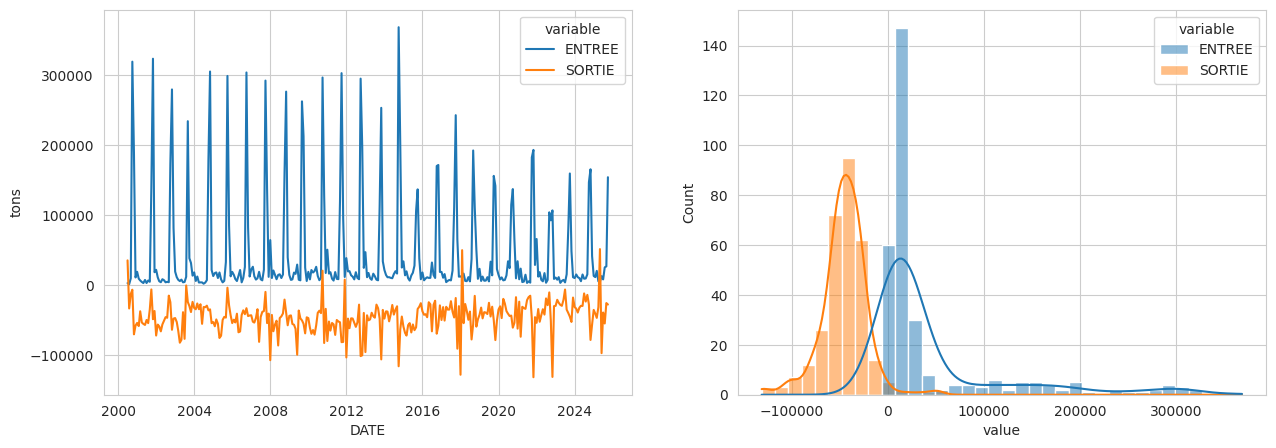

In [19]:
Trigger = ((fam_melt_df['ESPECES'] == espece)
           & (fam_melt_df['DEP'] == '01') )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.lineplot(fam_melt_df.loc[Trigger,:], 
             x = 'DATE', 
             y = 'value',   
             hue = 'variable',
             ax=axes[0]).set_ylabel('tons')


sns.histplot(fam_melt_df.loc[Trigger,:],
             x = 'value', 
             hue = 'variable',
             kde = True,
             ax = axes[1])

plt.show()

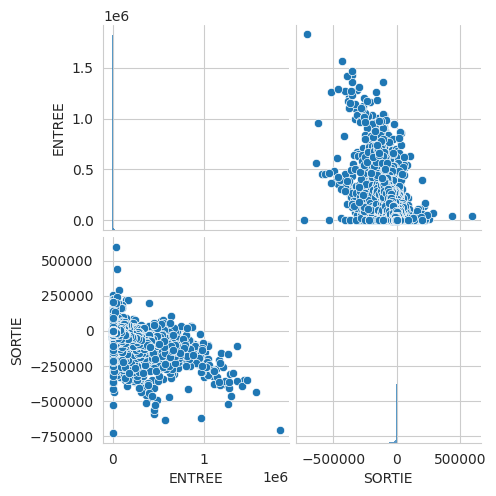

,ENTREE,SORTIE
ENTREE,1.000000,-0.556354
SORTIE,-0.556354,1.000000


In [20]:
Trigger = ((fam_df['ESPECES'] == espece)
           & (fam_df['DEP'] == '01') )

sns.pairplot(fam_df.loc[:, ['ENTREE','SORTIE']])

plt.show()

fam_df.loc[:, ['ENTREE','SORTIE']].corr()

# Temporal EDA conclusions:

## Relations among variables

I found the relation between variables and propose a simplifcation in two columns: 

- ENTREE : the sum of entry stocks from the farmers (purchases and deposit)
- SORTIE : the sum of exited stock, and the infered sales and purchases not from farmers. 

Why add purchases not from farmers to SORTIE? 

- Storage organism (OS) rarely buy from other actors than farmers. So, few purchases are seen, points above 0 are sparse on above graph.
- Purchases not from other farmer may include stock transfer of an OS when its area include multiple department.
- We can't distinguish them from sales.

## Variables dynamics

These variables have:

- Seasonality, especialy ENTREE where most of the variable occur during the harvst period short period. 
- Small but significant first order autocorrelation.
- A negative and non-linear correlation


## Proposed Preprocessing

- Add the two variables, delete the others. 
- streamline the pipeline before looking at ESDA


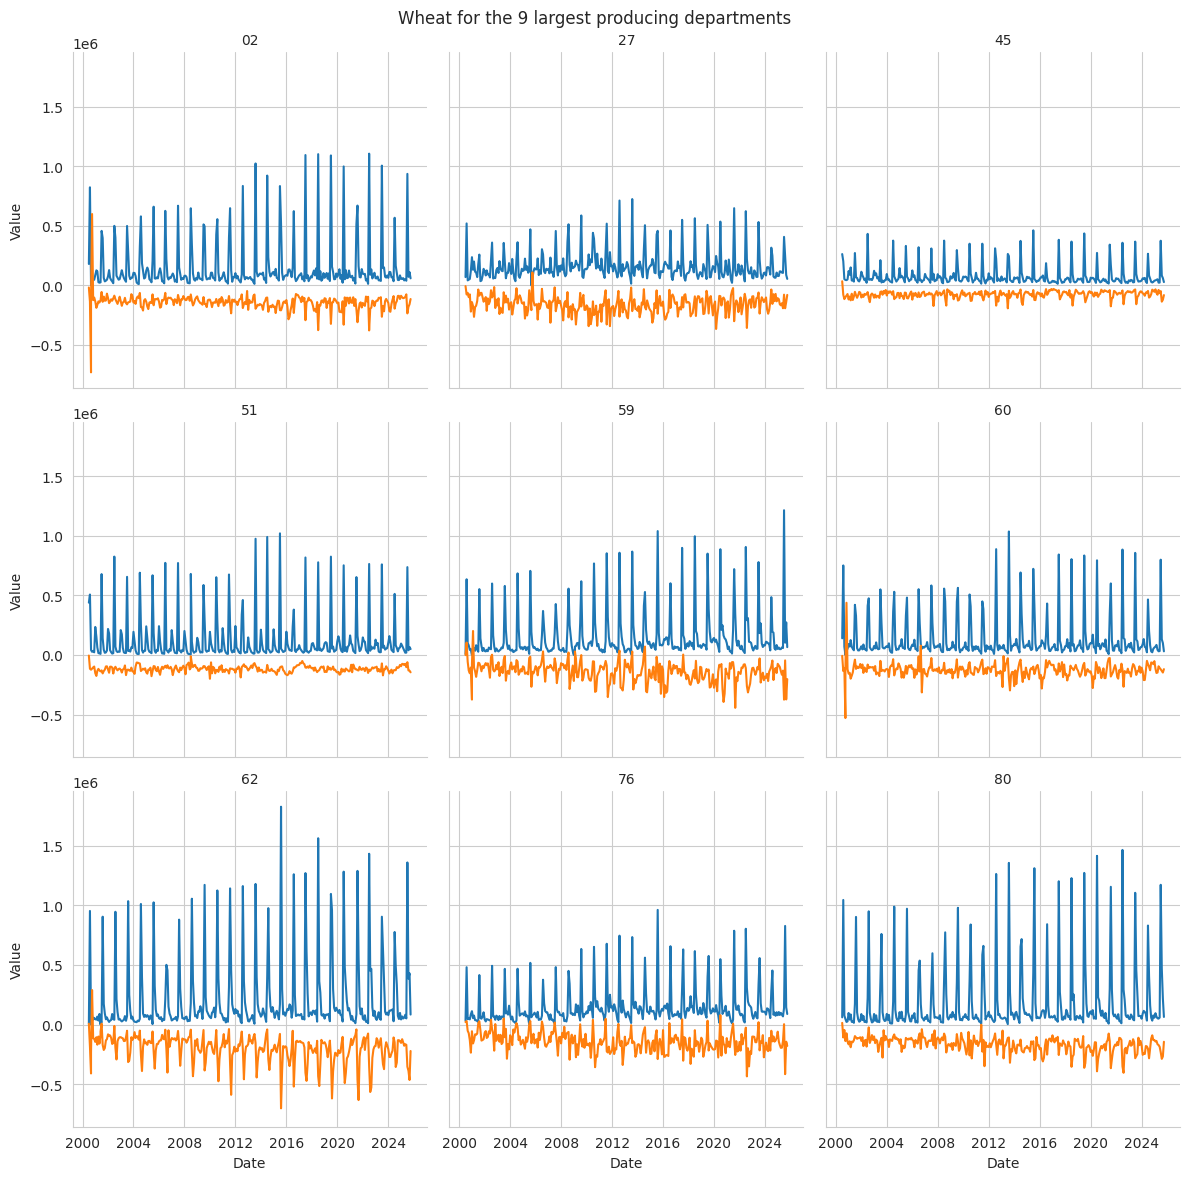

In [21]:
Largest_Prod_DEP = fam_melt_df.loc[fam_melt_df['variable']=="ENTREE",:].groupby('DEP').sum('value').sort_values('value',  ascending=False).index[1:10]

Trigger = ((fam_melt_df['DEP'].isin(Largest_Prod_DEP)) &
           (fam_melt_df['ESPECES'] == 'Blé tendre')
)


sns.set_style("whitegrid")

g = sns.FacetGrid(
    fam_melt_df.loc[Trigger,:],
    col="DEP",               # separate column for each DEP
    col_wrap=3,              
    height=4,
    hue = 'variable',
    sharex=True,
    sharey=True
)

g.map(
    sns.lineplot,
    "DATE", "value",
    estimator=None           # plot raw points
)

# Legend for ESPECES (appears once for the whole figure)

g.set_axis_labels("Date", "Value")
g.set_titles(col_template="{col_name}")

g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Wheat for the 9 largest producing departments')

plt.tight_layout()
plt.show()


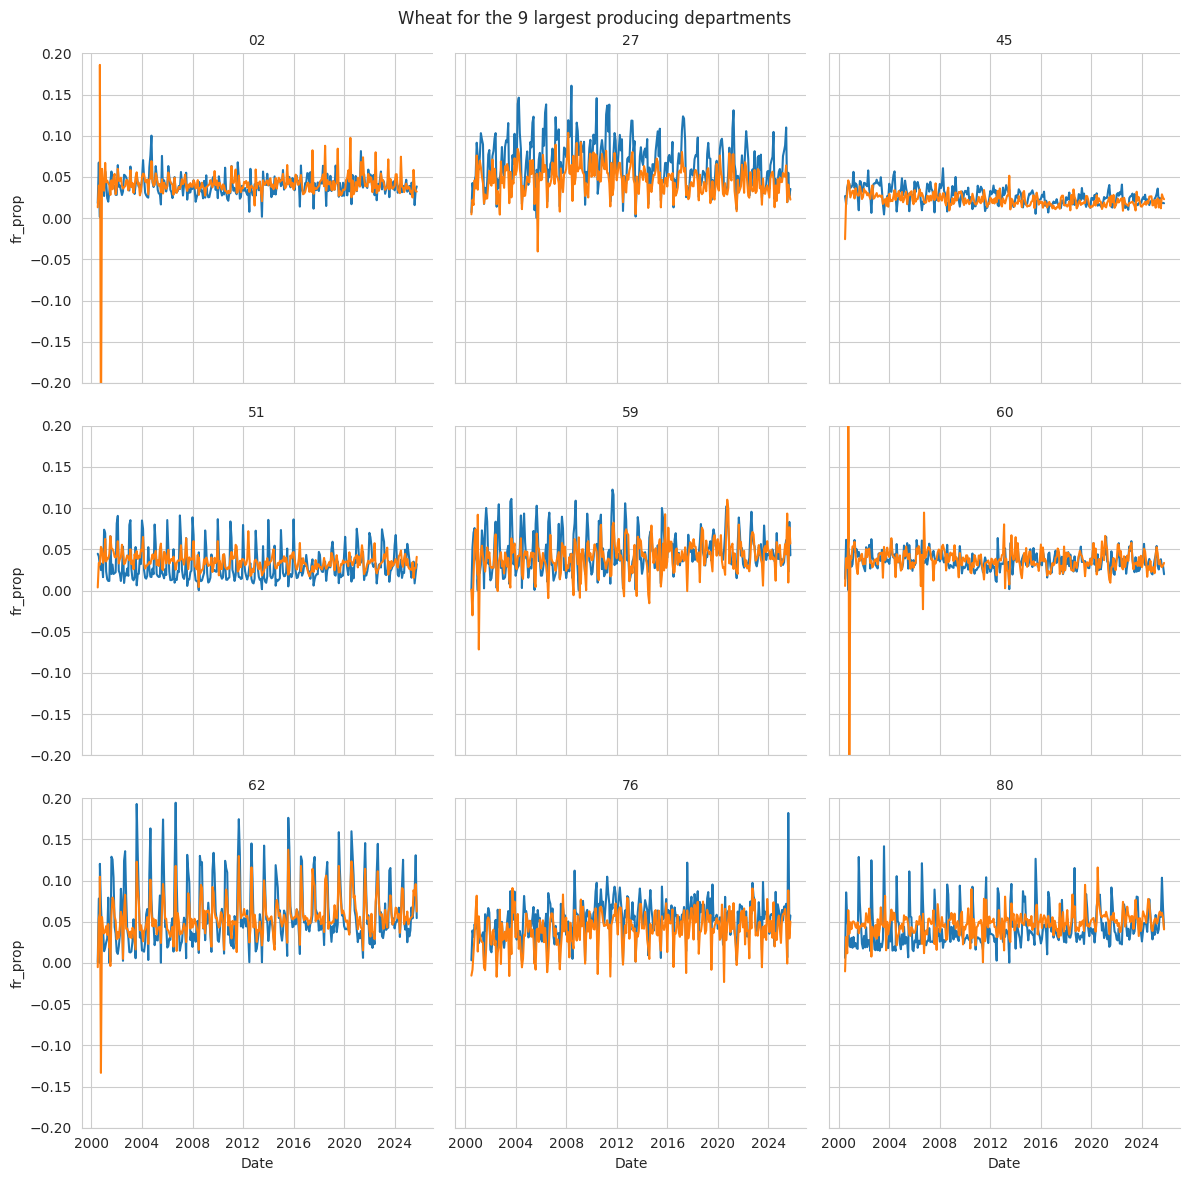

In [22]:
# Dividing department value by the France value: Proportion of the department to the France value. 
sum_dep = fam_melt_df.groupby(['DATE', 'ESPECES', 'variable'])['value'].transform('sum')
fam_melt_df['fr_prop'] = fam_melt_df['value'] / sum_dep


Trigger = ((fam_melt_df['DEP'].isin(Largest_Prod_DEP)) &
           (fam_melt_df['ESPECES'] == 'Blé tendre')
)

sns.set_style("whitegrid")

g = sns.FacetGrid(
    fam_melt_df.loc[Trigger,:],
    col="DEP",               # separate column for each DEP
    col_wrap=3,              
    height=4,
    hue = 'variable',
    sharex=True,
    sharey=True,
)

g.map(
    sns.lineplot,
    "DATE", "fr_prop",
    estimator=None
)

# Legend for ESPECES (appears once for the whole figure)

g.set_axis_labels("Date", "fr_prop")
g.set_titles(col_template="{col_name}")

g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Wheat for the 9 largest producing departments')

plt.ylim(-0.2,0.2)

plt.tight_layout()
plt.show()